In [1]:
from pyabc import (ABCSMC, Distribution, RV,
                   MultivariateNormalTransition)
import scipy as sp
import scipy.stats as st
import tempfile
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def model(parameter):
    return {"data": parameter["mean"] + sp.randn()}

In [3]:
prior = Distribution(mean=RV("uniform", 0, 5))

In [4]:
def distance(x, y):
    return abs(x["data"] - y["data"])

In [5]:
abc = ABCSMC(model, prior, distance)

In [6]:
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "test.db"))
observation = 2.5
abc.new(db_path, {"data": observation})

INFO:Epsilon:initial epsilon is 1.3908662743208229


INFO:History:Start <ABCSMC(id=16, start_time=2018-01-17 16:23:35.556818, end_time=None)>


16

In [7]:
history = abc.run(minimum_epsilon=.2, max_nr_populations=10)

INFO:ABC:t:0 eps:1.3908662743208229


INFO:ABC:t:1 eps:0.8530536700548883


INFO:ABC:t:2 eps:0.4713778943005849


INFO:ABC:t:3 eps:0.250543959634837


INFO:ABC:t:4 eps:0.11745723309029035


INFO:History:Done <ABCSMC(id=16, start_time=2018-01-17 16:23:35.556818, end_time=2018-01-17 16:23:50.374315)>


In [9]:
history is abc.history

True

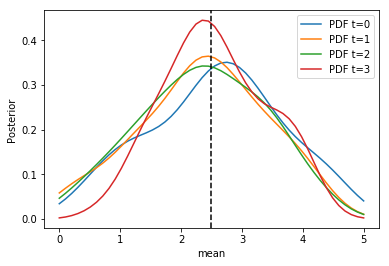

In [10]:
from pyabc.visualization import plot_kde_1d
fig, ax = plt.subplots()
for t in range(history.max_t+1):
    df, w = history.get_distribution(m=0, t=t)
    plot_kde_1d(df, w,
                xmin=0, xmax=5,
                x="mean", ax=ax,
                label="PDF t={}".format(t))
ax.axvline(observation, color="k", linestyle="dashed");
ax.legend();